In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from moviepy.editor import VideoFileClip
%matplotlib inline

### Camera calibration

In [2]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/cal*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)
    else:
        print("%s failed\n" % fname)

cv2.destroyAllWindows()

camera_cal/calibration4.jpg failed

camera_cal/calibration5.jpg failed

camera_cal/calibration1.jpg failed



### Distortion correction

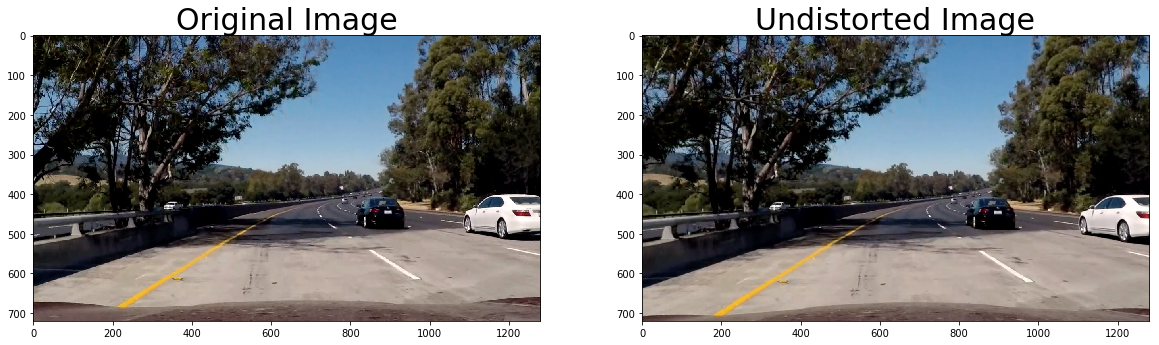

In [3]:
# Test undistortion on an image
img = cv2.imread('test_images/test5.jpg')
#img = cv2.imread('test_t6.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

img_undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=30)

### Create a thresholded binary image

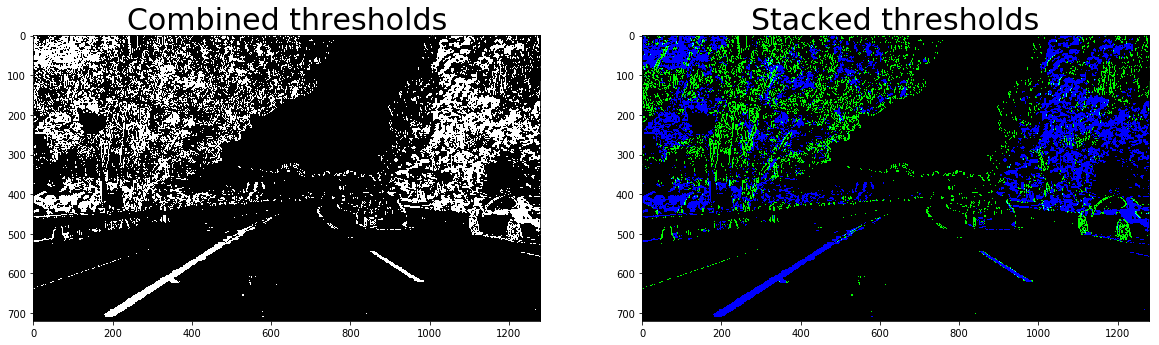

In [4]:
def threshold(img, s_thresh=(90, 255), sx_thresh=(30, 255), h_thresh=100):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (h_channel<h_thresh)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #color_binary = np.dstack(( np.zeros_like(sxbinary), np.zeros_like(sxbinary), s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        
    return color_binary, combined_binary

color_binary, combined_binary = threshold(img_undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Combined thresholds', fontsize=30)
ax1.imshow(combined_binary, cmap='gray')

ax2.imshow(color_binary)
ax2.set_title('Stacked thresholds', fontsize=30)


### Perspective transform

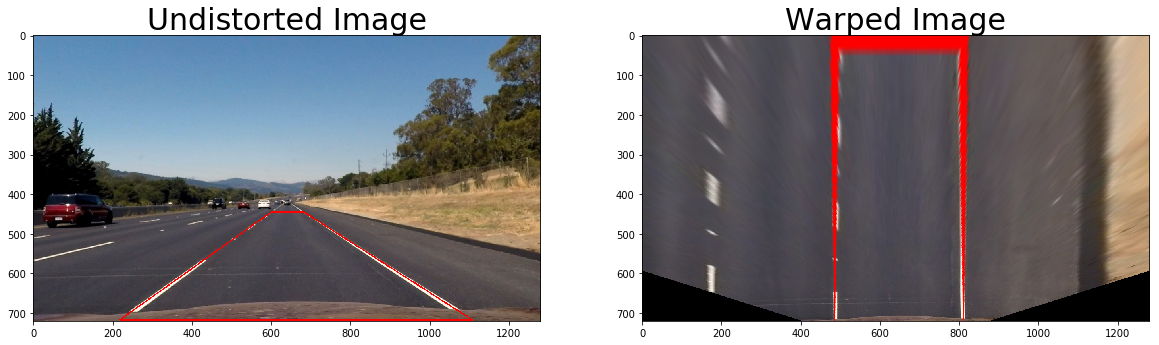

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
cal_img = cv2.imread('test_images/straight_lines2.jpg')
cal_img_size = (cal_img.shape[1], cal_img.shape[0])
cal_img_undist = cv2.cvtColor(cv2.undistort(cal_img, mtx, dist, None, mtx), cv2.COLOR_BGR2RGB)

# source points
src = np.float32([[218,717],[600,445],[682,445],[1107,717]])
#src = np.float32([[218,717],[609,440],[674,440],[1107,717]])

# destination points
r1 = 0.3
r2 = 1-r1
dst = np.float32([[(r1*src[0][0]+r2*src[1][0]), cal_img.shape[0]],
                  [(r1*src[0][0]+r2*src[1][0]), 0],
                  [(r2*src[2][0]+r1*src[3][0]), 0],
                  [(r2*src[2][0]+r1*src[3][0]), cal_img.shape[0]]])

ds = 0
verta = np.int32([[[src[0][0],src[0][1],src[1][0],src[1][1]],
                 [src[1][0],src[1][1],src[2][0],src[2][1]],
                 [src[2][0],src[2][1],src[3][0],src[3][1]],
                 [src[3][0],src[0][1],src[0][0],src[0][1]]]])

draw_lines(cal_img_undist, verta, color=[255,0,0], thickness=2)    

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(cal_img_undist, M, (cal_img.shape[1],cal_img.shape[0]))     

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cal_img_undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)


### Adding a mask

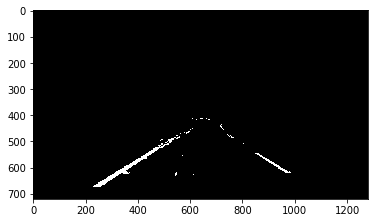

In [6]:
mask = np.zeros_like(combined_binary)    
imshape = mask.shape
vertices = np.array([[(100,imshape[0]-45),(imshape[1]/2-10, 400), (imshape[1]/2+10, 400), (imshape[1]-100,imshape[0]-45)]], dtype=np.int32)
cv2.fillPoly(mask, vertices, 1) 
plt.imshow(combined_binary*mask, cmap='gray')

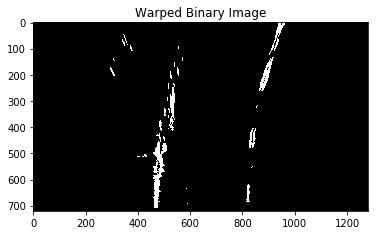

In [7]:
binary_warped = cv2.warpPerspective(combined_binary*mask, M, (combined_binary.shape[1],combined_binary.shape[0]))     
plt.figure()
ax = plt.subplot()
plt.imshow(binary_warped, cmap='gray')
ax.set_title('Warped Binary Image')


### Detect lane pixels and find the lane boundary

In [8]:
def getLanePixels(binary_warped, margin=80, nwindows=9):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/3):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 30
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds, nonzero


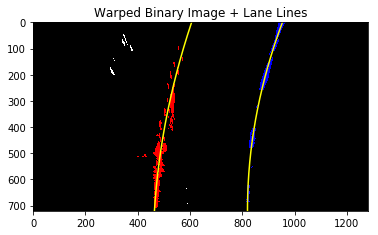

In [9]:
left_lane_inds, right_lane_inds, nonzero = getLanePixels(binary_warped) 

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
    
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure()
ax = plt.subplot()
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim([720,0])
ax.set_title('Warped Binary Image + Lane Lines')


### Radius of curvature of the lane

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 40/720 # meters per pixel in y dimension
xm_per_pix = 3.7/((src[2][0]+src[3][0])/2-(src[0][0]+src[1][0])/2) # meters per pixel in x dimension
fac1 = xm_per_pix/ym_per_pix  # for dx/dy
fac2 = xm_per_pix/ym_per_pix**2 # for dx^2/dy^2 

#evalute the curvature close to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (fac1*(2*left_fit[0]*y_eval + left_fit[1]))**2)**1.5) / np.absolute(2*fac2*left_fit[0])
right_curverad = ((1 + (fac1*(2*right_fit[0]*y_eval + right_fit[1]))**2)**1.5) / np.absolute(2*fac2*right_fit[0])
print('left curvature: %.0f m' % left_curverad)
print('right curvature: %.0f m' % right_curverad)

left curvature: 1076 m
right curvature: 780 m


### Vehicle position with respect to the center of the lane

In [12]:
veh_pos = binary_warped.shape[1]/2
lane_center = (left_fitx[-1]+right_fitx[-1])/2
veh_pos_rel = veh_pos - lane_center
print('vehicle position: %.1f pixel (%.3f m)' % (veh_pos_rel,veh_pos_rel*xm_per_pix))

vehicle position: -1.9 pixel (-0.014 m)


### Warp the detected lane boundaries back onto the original image after distortion correction

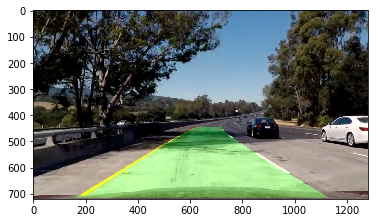

In [13]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB), 1, newwarp, 0.3, 0)
plt.imshow(result)

### Pipeline to process the video

In [14]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [15]:
leftLine = Line()
rightLine = Line()
usePrevious = False
midY = np.max(ploty) # to evaluate curvature

In [16]:
def process_image(img):
    # correct distortion
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # threshold binary image   
    s_thresh=(80, 255)
    sx_thresh=(30, 255)
    h_thresh=100
    hls = cv2.cvtColor(img_undist, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    h_channel = hls[:,:,0]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1]) & (h_channel<h_thresh)] = 1        
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1))] = 1       
    
    binary_warped = cv2.warpPerspective(combined_binary*mask, M, (combined_binary.shape[1],combined_binary.shape[0]))     

    # find lane pixels
    if usePrevious and leftLine.detected and rightLine.detected:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 80
        leftBound = leftLine.fit[0]*(nonzeroy**2) + leftLine.fit[1]*nonzeroy + leftLine.fit[2]
        rightBound = rightLine.fit[0]*(nonzeroy**2) + rightLine.fit[1]*nonzeroy + rightLine.fit[2]
        left_lane_inds = ((nonzerox > (leftBound - margin)) & (nonzerox < (leftBound + margin))) 
        right_lane_inds = ((nonzerox > (rightBound - margin)) & (nonzerox < (rightBound + margin)))  
    else:
        left_lane_inds, right_lane_inds, nonzero = getLanePixels(binary_warped, margin=80)
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1]) 
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #curvature
    left_curverad = ((1 + (fac1*(2*left_fit[0]*midY + left_fit[1]))**2)**1.5) / np.absolute(2*fac2*left_fit[0])
    right_curverad = ((1 + (fac1*(2*right_fit[0]*midY + right_fit[1]))**2)**1.5) / np.absolute(2*fac2*right_fit[0])
    
    if usePrevious:
        curvDiff = min(left_curverad,right_curverad)/max(left_curverad,right_curverad)
        if curvDiff > 0.1:
            leftLine.detected = True
            rightLine.detected = True
            leftLine.fit = left_fit
            rightLine.fit = right_fit
            leftLine.radius_of_curvature = left_curverad
            rightLine.radius_of_curvature = right_curverad
        else:
            leftLine.detected = False
            rightLine.detected = False
            left_fit = leftLine.fit
            right_fit = rightLine.fit
            print('left curvature: %.0f m %.4f' % (left_curverad,left_fit[0]))
            print('right curvature: %.0f m %.4f' % (right_curverad,right_fit[0]))
            
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    veh_pos = binary_warped.shape[1]/2
    lane_center = (left_fitx[-1]+right_fitx[-1])/2
    veh_pos_rel = (veh_pos - lane_center)*xm_per_pix*100 # in cm

    font = cv2.FONT_HERSHEY_SIMPLEX    
    txt1 = "  R: %5.0f, %5.0f m" % (left_curverad, right_curverad)
    txt2 = "pos: %4.0f cm" % (veh_pos_rel)    
    cv2.putText(result,txt1,(60,80),font,2,(255,0,0),2)
    cv2.putText(result,txt2,(60,140),font,2,(255,0,0),2) 
    return result
    


### Test on a tricky frame (very faint lane lines)

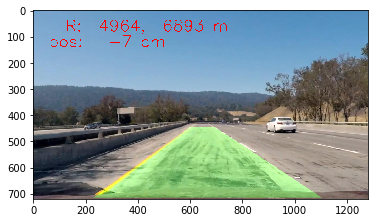

In [17]:
usePrevious = False
leftLine.detected = False
rightLine.detected = False

#clip0 = VideoFileClip('project_video.mp4')
#clip0.save_frame('test_t22.jpg', 22.2)

img = mpimg.imread('test_t22.jpg')
processed_img = process_image(img)
plt.figure()
plt.imshow(processed_img)

### Test on all other test images

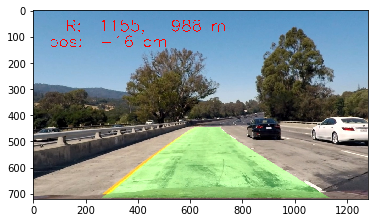

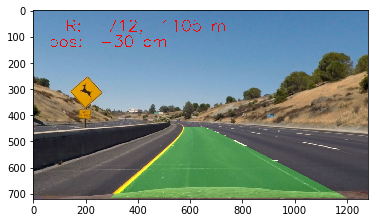

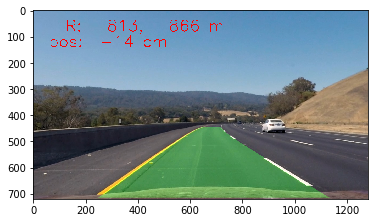

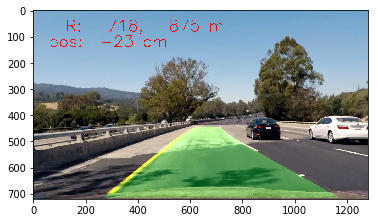

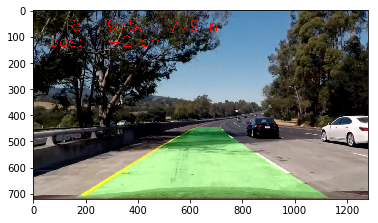

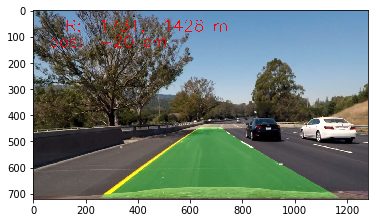

In [18]:
usePrevious = False
leftLine.detected = False
rightLine.detected = False
for i in range(1,7):
    img = mpimg.imread('test_images/test'+str(i)+'.jpg')
    processed_img = process_image(img)
    plt.figure()
    plt.imshow(processed_img)

In [19]:
usePrevious = True
leftLine.detected = False
rightLine.detected = False
#clip1 = VideoFileClip('project_video.mp4').subclip(0,5).fl_image(process_image)
clip1 = VideoFileClip('project_video.mp4').fl_image(process_image)
%time clip1.write_videofile('video.mp4', audio=False)

[MoviePy] >>>> Building video video.mp4
[MoviePy] Writing video video.mp4


 25%|██▍       | 314/1261 [00:58<03:04,  5.13it/s]

left curvature: 22255 m -0.0000
right curvature: 1745 m -0.0001


 25%|██▍       | 315/1261 [00:58<03:08,  5.01it/s]

left curvature: 68074 m -0.0000
right curvature: 1863 m -0.0001
left curvature: 20445 m -0.0000
right curvature: 1809 m -0.0001


 25%|██▌       | 318/1261 [00:58<03:15,  4.83it/s]

left curvature: 63214 m -0.0000
right curvature: 1864 m -0.0001


 25%|██▌       | 319/1261 [00:59<03:15,  4.83it/s]

left curvature: 58383 m -0.0000
right curvature: 1765 m -0.0001
left curvature: 74391 m -0.0000
right curvature: 1873 m -0.0001


 25%|██▌       | 321/1261 [00:59<03:01,  5.18it/s]

left curvature: 43029 m -0.0000
right curvature: 2223 m -0.0001


 26%|██▌       | 322/1261 [00:59<03:14,  4.83it/s]

left curvature: 53673 m -0.0000
right curvature: 2162 m -0.0001


 26%|██▌       | 323/1261 [00:59<03:15,  4.79it/s]

left curvature: 32075 m -0.0000
right curvature: 2368 m -0.0001
left curvature: 41081 m -0.0000
right curvature: 2186 m -0.0001


 26%|██▌       | 325/1261 [01:00<03:07,  4.99it/s]

left curvature: 68989 m -0.0000
right curvature: 2492 m -0.0001


 26%|██▌       | 326/1261 [01:00<03:24,  4.58it/s]

left curvature: 40668 m -0.0000
right curvature: 2375 m -0.0001


 26%|██▌       | 329/1261 [01:01<03:00,  5.18it/s]

left curvature: 41674 m 0.0000
right curvature: 2724 m -0.0001


 26%|██▌       | 331/1261 [01:01<03:13,  4.80it/s]

left curvature: 57631 m -0.0000
right curvature: 4279 m -0.0000


 28%|██▊       | 353/1261 [01:05<02:44,  5.54it/s]

left curvature: 39039 m 0.0000
right curvature: 2774 m -0.0001


 29%|██▉       | 365/1261 [01:08<02:40,  5.60it/s]

left curvature: 3097 m 0.0001
right curvature: 63904 m -0.0000


 34%|███▎      | 424/1261 [01:19<02:42,  5.14it/s]

left curvature: 265531 m -0.0000
right curvature: 25323 m 0.0000


 36%|███▌      | 449/1261 [01:24<02:28,  5.47it/s]

left curvature: 114178 m 0.0000
right curvature: 8120 m -0.0000


 38%|███▊      | 474/1261 [01:29<02:40,  4.91it/s]

left curvature: 56805 m -0.0000
right curvature: 3236 m -0.0000


 38%|███▊      | 476/1261 [01:29<02:38,  4.95it/s]

left curvature: 70301 m -0.0000
right curvature: 3226 m -0.0000


 38%|███▊      | 478/1261 [01:30<02:51,  4.57it/s]

left curvature: 51699 m 0.0000
right curvature: 3951 m -0.0001


 39%|███▉      | 491/1261 [01:32<02:33,  5.03it/s]

left curvature: 12628 m -0.0000
right curvature: 128338 m -0.0000


 39%|███▉      | 495/1261 [01:33<02:39,  4.81it/s]

left curvature: 6731 m -0.0000
right curvature: 76595 m 0.0000


 40%|███▉      | 500/1261 [01:34<02:27,  5.17it/s]

left curvature: 3673 m -0.0001
right curvature: 66442 m -0.0000


 40%|████      | 510/1261 [01:36<02:39,  4.70it/s]

left curvature: 8790 m -0.0000
right curvature: 1894860 m -0.0000


 41%|████      | 511/1261 [01:37<02:40,  4.67it/s]

left curvature: 170082 m -0.0000
right curvature: 9629 m -0.0000


 41%|████      | 517/1261 [01:38<02:24,  5.14it/s]

left curvature: 768600 m 0.0000
right curvature: 3450 m -0.0000


 41%|████      | 518/1261 [01:38<02:35,  4.77it/s]

left curvature: 40310 m 0.0000
right curvature: 2531 m -0.0000


 41%|████      | 519/1261 [01:38<02:34,  4.82it/s]

left curvature: 35019 m 0.0000
right curvature: 1570 m -0.0000


 43%|████▎     | 540/1261 [01:42<02:18,  5.20it/s]

left curvature: 30846 m 0.0000
right curvature: 2473 m 0.0001


 43%|████▎     | 545/1261 [01:43<02:24,  4.96it/s]

left curvature: 19462 m -0.0000
right curvature: 1716 m 0.0001


 44%|████▍     | 552/1261 [01:45<02:31,  4.68it/s]

left curvature: 4011 m -0.0000
right curvature: 155064 m -0.0000


 44%|████▍     | 558/1261 [01:46<02:27,  4.76it/s]

left curvature: 456071 m -0.0000
right curvature: 3298 m -0.0001


 45%|████▍     | 563/1261 [01:47<02:17,  5.09it/s]

left curvature: 392452 m -0.0000
right curvature: 7192 m -0.0000


 45%|████▍     | 565/1261 [01:48<02:31,  4.59it/s]

left curvature: 25315 m -0.0000
right curvature: 2057 m -0.0001


 45%|████▌     | 568/1261 [01:48<02:34,  4.50it/s]

left curvature: 153030 m -0.0000
right curvature: 12400 m -0.0000


 46%|████▋     | 584/1261 [01:52<02:24,  4.69it/s]

left curvature: 26155 m 0.0000
right curvature: 2069 m 0.0001


 80%|████████  | 1011/1261 [03:14<00:55,  4.50it/s]

left curvature: 76236 m 0.0000
right curvature: 1019 m 0.0002


 81%|████████  | 1020/1261 [03:16<00:56,  4.28it/s]

left curvature: 303704 m 0.0000
right curvature: 1554 m 0.0002


 99%|█████████▉| 1249/1261 [04:02<00:02,  5.00it/s]

left curvature: 413024 m 0.0000
right curvature: 1908 m -0.0001


 99%|█████████▉| 1250/1261 [04:02<00:02,  4.96it/s]

left curvature: 72041 m 0.0000
right curvature: 2250 m -0.0001
left curvature: 418740 m 0.0000
right curvature: 2144 m -0.0001


 99%|█████████▉| 1252/1261 [04:03<00:01,  5.24it/s]

left curvature: 90497 m 0.0000
right curvature: 2100 m -0.0001


 99%|█████████▉| 1253/1261 [04:03<00:01,  4.77it/s]

left curvature: 19021 m 0.0000
right curvature: 1019 m -0.0001


 99%|█████████▉| 1254/1261 [04:03<00:01,  4.75it/s]

left curvature: 29008 m 0.0000
right curvature: 1688 m -0.0001


100%|█████████▉| 1256/1261 [04:04<00:00,  5.20it/s]

left curvature: 19171 m -0.0000
right curvature: 864 m -0.0001


100%|█████████▉| 1258/1261 [04:04<00:00,  4.85it/s]

left curvature: 15051 m -0.0000
right curvature: 741 m -0.0001
left curvature: 16819 m -0.0000
right curvature: 685 m -0.0001


100%|█████████▉| 1260/1261 [04:04<00:00,  5.20it/s]


left curvature: 12653 m -0.0000
right curvature: 630 m -0.0001
[MoviePy] Done.
[MoviePy] >>>> Video ready: video.mp4 

CPU times: user 2min 13s, sys: 1.23 s, total: 2min 14s
Wall time: 4min 7s
